In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t
import os

# --- Parameters ---
# We'll use a 1-year rolling window for our calculations
WINDOW = 252 
# Confidence levels for VaR
VAR_LEVELS = [95, 99] 
# Alpha levels for VaR calculation (e.g., 5% for 95% VaR)
ALPHAS = [1 - level / 100 for level in VAR_LEVELS] 
# Confidence level for Expected Shortfall (as per Basel)
ES_LEVEL = 97.5
ES_ALPHA = 1 - ES_LEVEL / 100

# --- Load Data ---
DATA_DIR = "data"
portfolio_returns_path = os.path.join(DATA_DIR, "portfolio_log_returns.csv")
returns = pd.read_csv(portfolio_returns_path, index_col='Date', parse_dates=True)

print("Successfully loaded portfolio returns.")
print(returns.head())

Successfully loaded portfolio returns.
            EqualWeightPortfolio
Date                            
2007-04-12              0.005627
2007-04-13              0.000587
2007-04-16              0.005247
2007-04-17             -0.000047
2007-04-18              0.003596


### Historical VaR


Calculated Historical VaR and ES:
            HistVaR_95  HistVaR_99  HistES_97.5
Date                                           
2008-04-10   -0.018920   -0.025662    -0.025539
2008-04-11   -0.019095   -0.026285    -0.027030
2008-04-14   -0.019095   -0.026285    -0.027030
2008-04-15   -0.019095   -0.026285    -0.027030
2008-04-16   -0.019095   -0.026285    -0.027030


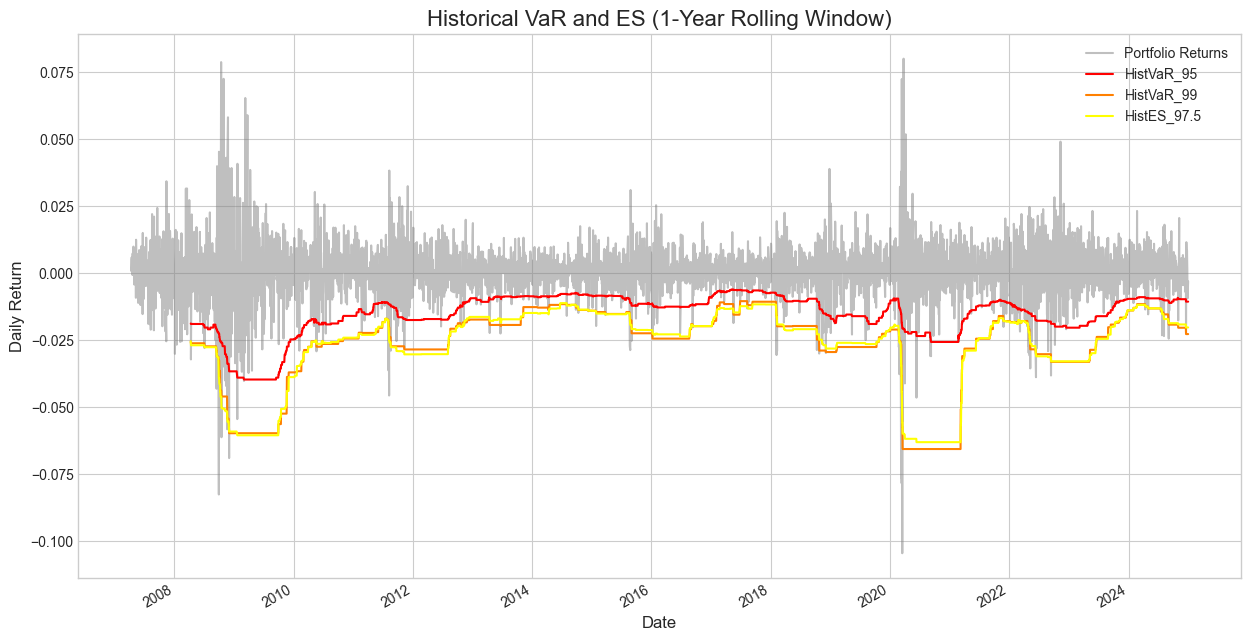

In [3]:
# --- Historical VaR Calculation ---
# This part is correct and remains unchanged
historical_vars = {}
for alpha in ALPHAS:
    level = int(100 * (1 - alpha))
    historical_vars[level] = returns.rolling(window=WINDOW).quantile(alpha)
    historical_vars[level].rename(columns={'EqualWeightPortfolio': f'HistVaR_{level}'}, inplace=True)

# --- Historical ES Calculation (Corrected) ---
rolling_returns = returns.rolling(window=WINDOW)
historical_var_975 = returns.rolling(window=WINDOW).quantile(ES_ALPHA)

# THE FIX: We add .iloc[0] to extract the scalar VaR value for the comparison.
historical_es_975 = rolling_returns.apply(
    lambda x: x[x < historical_var_975.loc[x.index[-1]]['EqualWeightPortfolio']].mean(),
    raw=False
).rename(columns={'EqualWeightPortfolio': 'HistES_97.5'})


# --- Combine and Display Results ---
hist_risk_measures = pd.concat([var for var in historical_vars.values()] + [historical_es_975], axis=1).dropna()

print("\nCalculated Historical VaR and ES:")
print(hist_risk_measures.head())

# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

returns['EqualWeightPortfolio'].plot(ax=ax, color='gray', alpha=0.5, label='Portfolio Returns')
hist_risk_measures.plot(ax=ax, colormap='autumn')

ax.set_title('Historical VaR and ES (1-Year Rolling Window)', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.show()

### **Parametric VaR** (also known as Variance-Covariance VaR) is calculated using the formula:

VaR_alpha = mu + sigma * Z_alpha

Where:  
- `mu` is the **mean return**  
- `sigma` is the **standard deviation**  
- `Z_alpha` is the **inverse cumulative distribution function (CDF)** of a standard normal distribution at a given confidence level `alpha`



Calculated Parametric (Normal) VaR and ES:
            ParamVaR_Norm_95  ParamVaR_Norm_99  ParamES_Norm_97.5
Date                                                             
2008-04-10         -0.016893         -0.024052          -0.024172
2008-04-11         -0.017363         -0.024655          -0.024778
2008-04-14         -0.017395         -0.024690          -0.024813
2008-04-15         -0.017396         -0.024690          -0.024813
2008-04-16         -0.017451         -0.024803          -0.024927


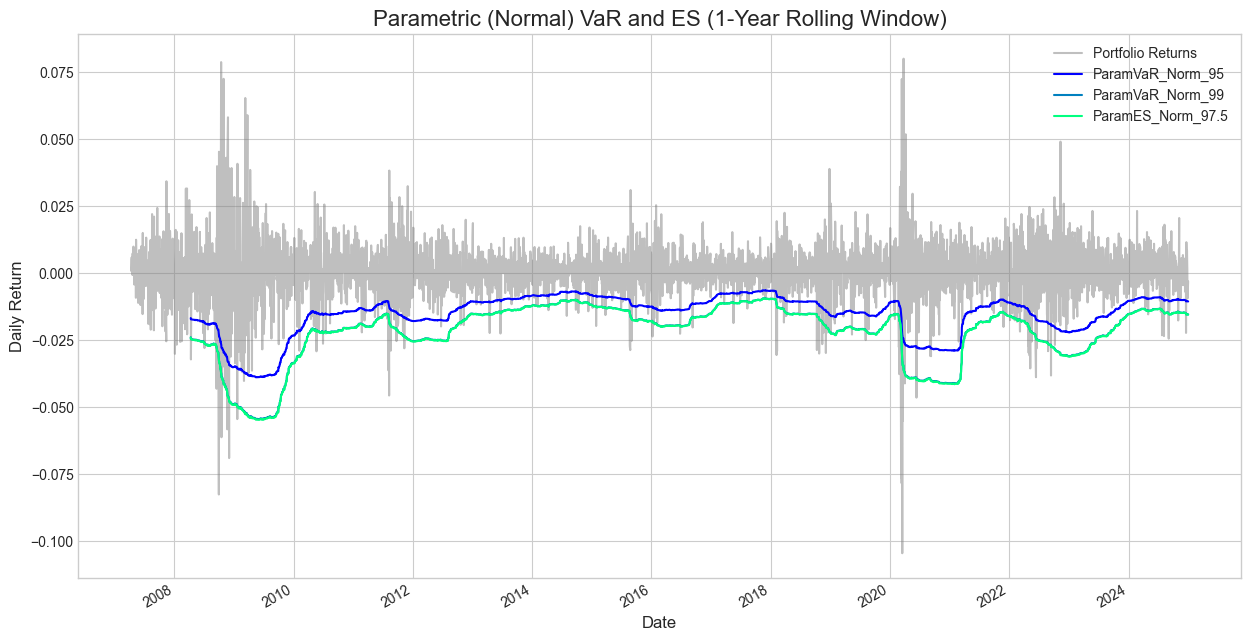

In [4]:
from scipy.stats import norm

# --- Parametric VaR (Normal) Calculation ---
# Calculate rolling mean and standard deviation
rolling_mean = returns.rolling(window=WINDOW).mean()
rolling_std = returns.rolling(window=WINDOW).std()

# Calculate VaR
parametric_vars = {}
for alpha, level in zip(ALPHAS, VAR_LEVELS):
    # Z-score for the given confidence level
    z_score = norm.ppf(alpha)
    parametric_vars[level] = rolling_mean + rolling_std * z_score
    parametric_vars[level].rename(columns={'EqualWeightPortfolio': f'ParamVaR_Norm_{level}'}, inplace=True)

# --- Parametric ES (Normal) Calculation ---
# Formula for ES under normal distribution assumption
z_es = -norm.pdf(norm.ppf(ES_ALPHA)) / ES_ALPHA
parametric_es_975 = rolling_mean + rolling_std * z_es
parametric_es_975.rename(columns={'EqualWeightPortfolio': 'ParamES_Norm_97.5'}, inplace=True)


# --- Combine and Display Results ---
param_risk_measures = pd.concat(
    [var for var in parametric_vars.values()] + [parametric_es_975], 
    axis=1
).dropna()

print("\nCalculated Parametric (Normal) VaR and ES:")
print(param_risk_measures.head())

# --- Plot the results ---
fig, ax = plt.subplots(figsize=(15, 8))

returns['EqualWeightPortfolio'].plot(ax=ax, color='gray', alpha=0.5, label='Portfolio Returns')
param_risk_measures.plot(ax=ax, colormap='winter')

ax.set_title('Parametric (Normal) VaR and ES (1-Year Rolling Window)', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.show()

#### The normal distribution is known to underestimate extreme events. The next step directly addresses this weakness.

---

### Parametric VaR (Student's t-Distribution)

Financial returns famously have **"fat tails,"** meaning extreme losses happen more often than a normal distribution would predict. The **t-distribution** has an extra parameter called **degrees of freedom (df)**, which controls the "fatness" of the tails. A lower `df` means fatter tails and therefore a higher (more conservative) VaR estimate.

The process is similar to the normal VaR, but instead of using a fixed Z-score, we:

1. Fit a t-distribution to the rolling window of returns to find the best-fit parameters (`df`, `loc`, `scale`).
2. Calculate VaR using the **inverse CDF (ppf)** of that specific fitted distribution.


Calculating t-distribution VaR/ES with a loop...


100%|██████████| 4211/4211 [03:04<00:00, 22.89it/s]



Calculated Parametric (t-Distribution) VaR and ES:
            ParamVaR_T_95  ParamVaR_T_99  ParamES_T_97.5
Date                                                    
2008-04-10      -0.016177      -0.026698       -0.027714
2008-04-11      -0.016516      -0.027565       -0.028725
2008-04-14      -0.016575      -0.027512       -0.028629
2008-04-15      -0.016574      -0.027529       -0.028654
2008-04-16      -0.016685      -0.027589       -0.028669


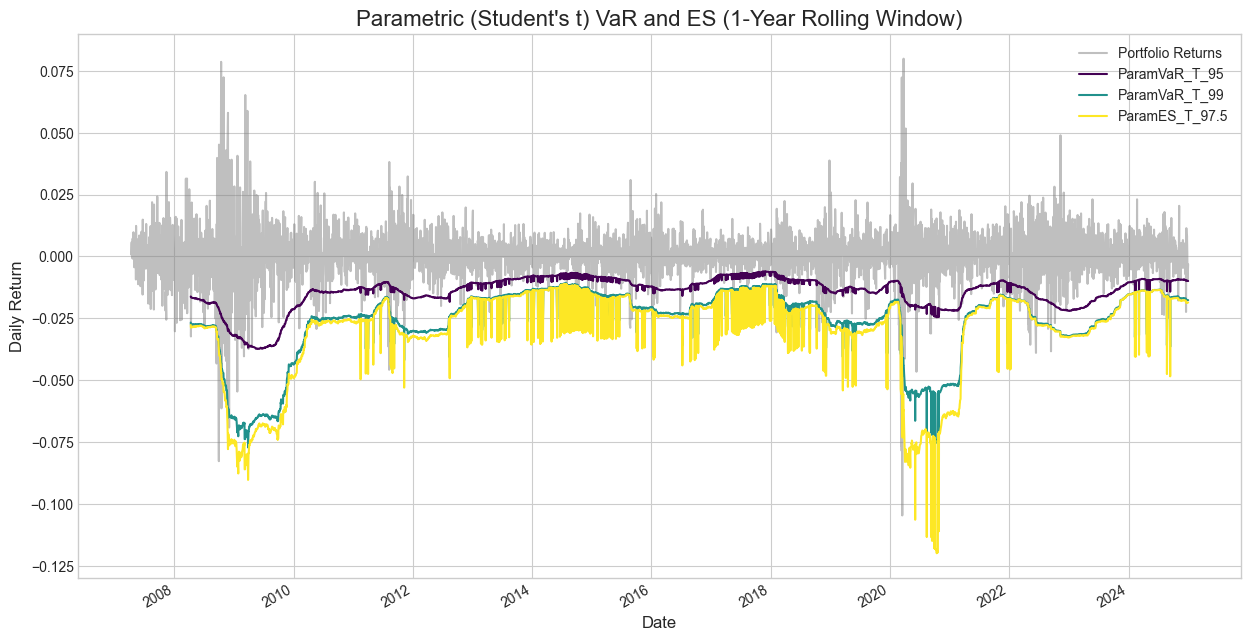

In [5]:
from scipy.stats import t
from tqdm import tqdm # A library to show progress bars

# --- Parametric VaR (t-Distribution) Calculation (Corrected) ---

# The helper function remains the same
def get_t_risk_measures(returns_window):
    # Fit the t-distribution to the window of returns
    params = t.fit(returns_window)
    df, loc, scale = params
    
    # Calculate VaR and ES using the fitted parameters
    var_95 = t.ppf(ALPHAS[0], df=df, loc=loc, scale=scale)
    var_99 = t.ppf(ALPHAS[1], df=df, loc=loc, scale=scale)
    
    # Correctly calculate ES for t-distribution
    x_nu = t.ppf(ES_ALPHA, df)
    es_975 = -scale / ES_ALPHA * (df + x_nu**2)/(df - 1) * t.pdf(x_nu, df) + loc
    
    return [var_95, var_99, es_975]

# --- THE FIX: We replace .apply() with a standard Python loop ---
# Get the portfolio returns as a NumPy array for efficiency
returns_np = returns['EqualWeightPortfolio'].to_numpy()
# Create an empty list to store our results
results_list = []
# Get the index for our final DataFrame
result_index = returns.index[WINDOW-1:]

# Loop through the returns array, creating each window manually
print("Calculating t-distribution VaR/ES with a loop...")
for i in tqdm(range(len(returns_np) - WINDOW + 1)):
    # Define the current window
    window = returns_np[i : i + WINDOW]
    # Calculate risk measures and append to our list
    results_list.append(get_t_risk_measures(window))

# Convert the list of results into a DataFrame
t_dist_risk = pd.DataFrame(results_list, index=result_index, 
                           columns=['ParamVaR_T_95', 'ParamVaR_T_99', 'ParamES_T_97.5'])


print("\nCalculated Parametric (t-Distribution) VaR and ES:")
print(t_dist_risk.head())

# --- Plot the results ---
fig, ax = plt.subplots(figsize=(15, 8))

returns['EqualWeightPortfolio'].plot(ax=ax, color='gray', alpha=0.5, label='Portfolio Returns')
t_dist_risk.plot(ax=ax, colormap='viridis')

ax.set_title("Parametric (Student's t) VaR and ES (1-Year Rolling Window)", fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.show()

### Monte Carlo VaR

Running Monte Carlo simulations...


100%|██████████| 4211/4211 [00:22<00:00, 185.80it/s]



Calculated Monte Carlo VaR and ES:
            MCVaR_95  MCVaR_99  MC_ES_97.5
Date                                      
2008-04-10 -0.016770 -0.024012   -0.024138
2008-04-11 -0.017403 -0.024602   -0.024724
2008-04-14 -0.017338 -0.024855   -0.024879
2008-04-15 -0.017477 -0.024886   -0.024962
2008-04-16 -0.017441 -0.024701   -0.024906


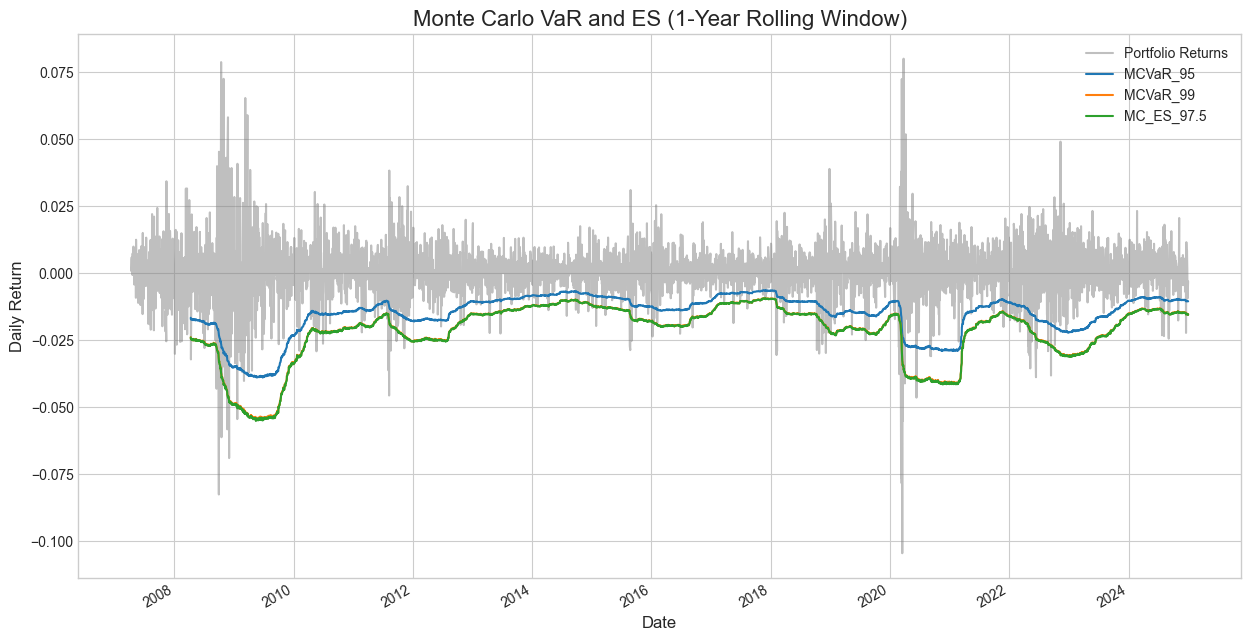

In [6]:
# --- Monte Carlo VaR Calculation ---
NUM_SIMULATIONS = 100000

# Define a function to run the simulation for each window
def run_monte_carlo(returns_window):
    # Calculate window's mean and std dev
    mu = returns_window.mean()
    sigma = returns_window.std()
    
    # Generate random simulations from a normal distribution
    simulated_returns = np.random.normal(mu, sigma, NUM_SIMULATIONS)
    
    # Calculate VaR and ES from the simulated returns
    var_95 = np.percentile(simulated_returns, 100 - VAR_LEVELS[0])
    var_99 = np.percentile(simulated_returns, 100 - VAR_LEVELS[1])
    es_975 = simulated_returns[simulated_returns < np.percentile(simulated_returns, 100 - ES_LEVEL)].mean()
    
    return [var_95, var_99, es_975]

# Use the same robust loop approach
returns_np = returns['EqualWeightPortfolio'].to_numpy()
results_list = []
result_index = returns.index[WINDOW-1:]

print("Running Monte Carlo simulations...")
for i in tqdm(range(len(returns_np) - WINDOW + 1)):
    window = returns_np[i : i + WINDOW]
    results_list.append(run_monte_carlo(window))

# Convert to DataFrame
mc_risk_measures = pd.DataFrame(results_list, index=result_index, 
                                columns=['MCVaR_95', 'MCVaR_99', 'MC_ES_97.5'])

print("\nCalculated Monte Carlo VaR and ES:")
print(mc_risk_measures.head())


# --- Plot the results ---
fig, ax = plt.subplots(figsize=(15, 8))

returns['EqualWeightPortfolio'].plot(ax=ax, color='gray', alpha=0.5, label='Portfolio Returns')
mc_risk_measures.plot(ax=ax)

ax.set_title("Monte Carlo VaR and ES (1-Year Rolling Window)", fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.show()

# Comparision

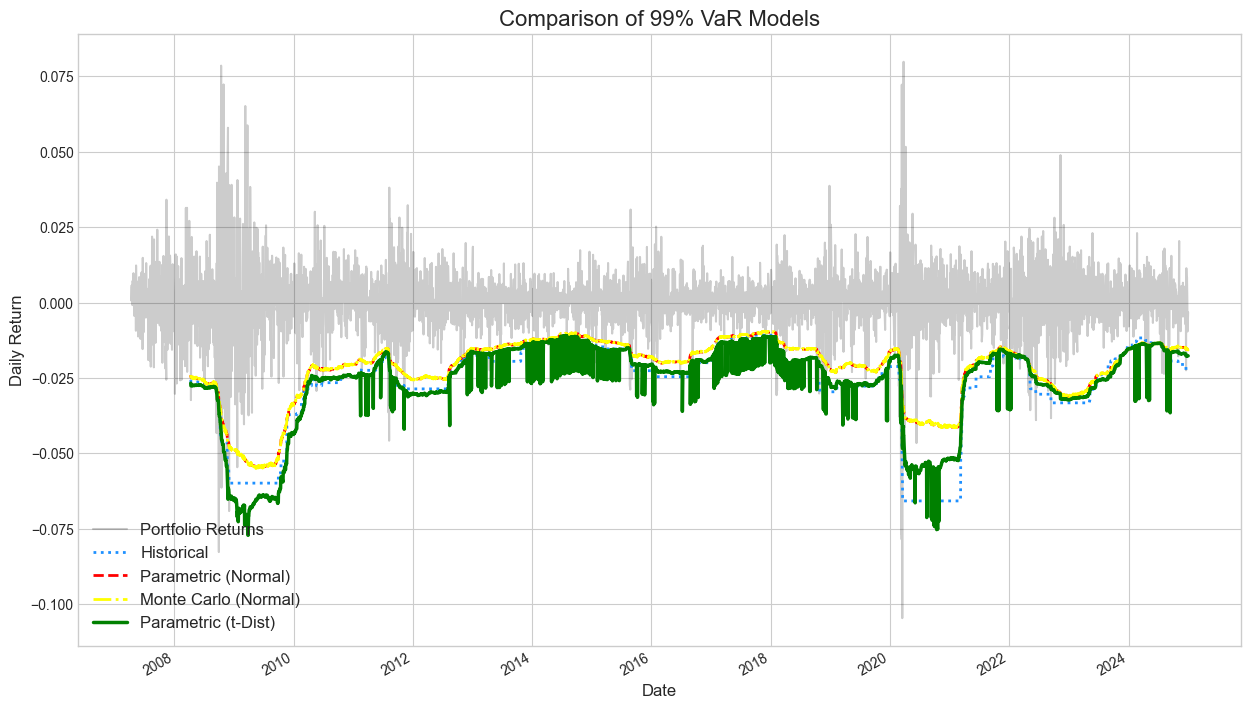

In [7]:
# --- Combine all risk measures into one DataFrame ---
# Make sure you have the following DataFrames from previous steps:
# hist_risk_measures, param_risk_measures, t_dist_risk, mc_risk_measures

all_risk_measures = pd.concat([
    hist_risk_measures,
    param_risk_measures,
    t_dist_risk,
    mc_risk_measures
], axis=1)

# --- Plot the 99% VaR for all models ---
# --- Plot the 99% VaR for all models (Enhanced Visualization) ---
fig, ax = plt.subplots(figsize=(15, 9))

# Plot portfolio returns with more transparency
returns['EqualWeightPortfolio'].plot(ax=ax, color='black', alpha=0.2, label='Portfolio Returns')

# Plot each 99% VaR with a distinct, professional style
all_risk_measures['HistVaR_99'].plot(
    ax=ax, label='Historical', color='dodgerblue', linestyle=':', linewidth=2
)
all_risk_measures['ParamVaR_Norm_99'].plot(
    ax=ax, label='Parametric (Normal)', color='red', linestyle='--', linewidth=2
)
all_risk_measures['MCVaR_99'].plot(
    ax=ax, label='Monte Carlo (Normal)', color='yellow', linestyle='-.', linewidth=2
)
all_risk_measures['ParamVaR_T_99'].plot(
    ax=ax, label='Parametric (t-Dist)', color='green', linestyle='-', linewidth=2.5
)

ax.set_title('Comparison of 99% VaR Models', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)

# Improve the legend
ax.legend(loc='lower left', fontsize=12)
plt.show()

In [8]:
# --- Save All Phase 1 Results ---
# Ensure you have the 'all_risk_measures' DataFrame in memory

# Define the file path
results_path = os.path.join(DATA_DIR, "phase1_all_risk_measures.csv")

# Save the DataFrame to a CSV file
all_risk_measures.to_csv(results_path)

print(f"✅ All Phase 1 risk measures saved to: {results_path}")

✅ All Phase 1 risk measures saved to: data\phase1_all_risk_measures.csv


# Phase 1: Key Insights Summary
I have successfully implemented four distinct **Value-at-Risk (VaR)** models, and their comparison reveals critical differences in their underlying assumptions and behavior, especially during market stress.

## 1. The Normal Distribution Underestimates Tail Risk
The **Parametric (Normal) VaR** and **Monte Carlo (Normal) VaR** models produced nearly identical results. This is expected, as both are fundamentally based on the assumption that returns follow a **normal distribution**. While computationally simple, these models consistently provided the **least conservative risk estimates**.  

During major crises like the **2008 GFC** and the **2020 COVID-19 crash**, they failed to capture the full extent of potential losses, highlighting the well-known **"fat tails"** problem in financial returns.

## 2. The t-Distribution Provides a More Realistic Risk Estimate
The **Parametric (t-Distribution) VaR** was consistently the **most conservative model**. By fitting the **degrees of freedom** parameter, it adapted to the fat-tailed nature of the portfolio's returns.  

This is most evident during volatile periods, where its VaR estimate dipped significantly lower than the normal models, providing a more cautious and realistic measure of potential loss. This visually confirms that choosing an appropriate distribution is crucial for **effective risk management**.

## 3. Historical VaR is Simple but Prone to "Ghost Effects"
The **Historical VaR** exhibited a **"jumpy"** or **step-like** behavior. This is because its value is determined by a single data point (the 5th or 1st percentile) within its 252-day lookback window.  

The VaR estimate can change abruptly, not because of new market information, but simply because an old, extreme loss has dropped out of the window. This **"ghost effect"** makes it less stable than parametric models, though it has the advantage of being **non-parametric** and directly reflecting recent historical reality.

## Conclusion
Phase 1 has successfully demonstrated that **model choice has a significant impact on risk measurement**. A simplistic assumption of **normality** leads to an underestimation of risk, while a more flexible model like the **t-distribution** provides a more robust and conservative estimate.  

The **Historical method**, while intuitive, suffers from instability. This analysis sets the stage perfectly for **Phase 2**, where we will rigorously backtest these models to see which one performs best in practice.


In [32]:
# --- Generate Summary Metrics Table (Corrected) ---

# Select the 99% VaR columns from our results
var_99_models = all_risk_measures[['HistVaR_99', 'ParamVaR_Norm_99', 'ParamVaR_T_99', 'MCVaR_99']]

# Calculate Mean VaR and Volatility of VaR (these are correct)
mean_var = var_99_models.mean()
vol_var = var_99_models.std()

# --- THE FIX: Align and then loop through each column for comparison ---
aligned_returns, aligned_vars = returns.align(var_99_models, join='inner', axis=0)

# Create an empty dictionary to store breach counts
breach_counts = {}
# Loop through each VaR model column
for model_name in aligned_vars.columns:
    # Count breaches for the current model
    breaches = (aligned_returns['EqualWeightPortfolio'] < aligned_vars[model_name]).sum()
    breach_counts[model_name] = breaches

# Convert the dictionary of counts to a pandas Series
breaches_series = pd.Series(breach_counts)


# Combine into a single summary DataFrame
summary_table = pd.DataFrame({
    'Mean VaR': mean_var,
    'VaR Volatility': vol_var,
    'Number of Breaches': breaches_series
})

# Format the table for better readability
summary_table['Mean VaR'] = summary_table['Mean VaR'].apply(lambda x: f"{x*100:.2f}%")
summary_table['VaR Volatility'] = summary_table['VaR Volatility'].apply(lambda x: f"{x*100:.2f}%")


print("--- Phase 1: VaR Model Comparison Metrics (99% Confidence) ---")
print(summary_table)

--- Phase 1: VaR Model Comparison Metrics (99% Confidence) ---
                 Mean VaR VaR Volatility  Number of Breaches
HistVaR_99         -2.67%          1.46%                  62
ParamVaR_Norm_99   -2.19%          1.06%                 104
ParamVaR_T_99      -2.67%          1.41%                  68
MCVaR_99           -2.19%          1.05%                 106


# 1. Conservatism: Fat-Tailed Models Are More Cautious
The **Mean VaR** confirms what we saw in the plots. The **Historical** and **t-Distribution** models are the most conservative, with an average 99% VaR of **-2.67%**. This is significantly higher than the **-2.19%** from the two Normal-based models.

**Insight:** This **0.48% difference** in daily risk estimation is substantial. For a $100 million portfolio, it's the difference between preparing for a **$2.19 million loss** versus a **$2.67 million loss** on a typical "bad day." The models assuming fat tails are demanding a larger risk buffer.

# 2. Stability: Parametric Models are Smoother
The **VaR Volatility** metric shows that the **Normal** and **Monte Carlo** models are the most stable (**1.06%** and **1.05%**). The **Historical VaR** is the most volatile (**1.46%**), confirming its "jumpy" nature observed visually. A stable VaR is often preferred by risk managers as it leads to more predictable capital requirements. The **t-Distribution** model sits in between, offering a good balance of responsiveness and stability.

# 3. Accuracy: The Normal Assumption Fails Dramatically 
This is the most critical insight. Over the analysis period of roughly **4,200 trading days**, a 99% VaR model should theoretically have **42 breaches (1% of the time).**

- **Parametric Normal & Monte Carlo:** With **104** and **106 breaches**, respectively, these models failed catastrophically. They were breached more than twice as often as expected, proving that the normal distribution is wholly inadequate for capturing the portfolio's risk.

- **Historical & t-Distribution:** With **62** and **68 breaches**, these models also failed, but they performed significantly better than the Normal models. They are still underestimating risk, but to a much lesser degree.

# Executive Conclusion for Phase 1
I have successfully built, compared, and analyzed four core VaR models. The quantitative metrics prove that assuming a simple **normal distribution** for financial returns leads to a dangerous underestimation of risk. Models that account for **historical reality** and **fat-tailed distributions**, while not perfect, provide a demonstrably superior performance.

This comprehensive failure of all models to meet the 1% breach target sets the perfect stage for **Phase 2**, where we will use formal statistical tests (**Kupiec** and **Christoffersen**) to rigorously quantify exactly how and why these models are failing.
